In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/all-pokemon-dataset/All_Pokemon.csv


изначальный набор данных, описание параметров на ходится на страничке набора данных на кагле

In [2]:
df = pd.read_csv('../input/all-pokemon-dataset/All_Pokemon.csv')
df.head()

,Number,Name,Type 1,Type 2,Abilities,HP,Att,Def,Spa,Spd,...,Against Bug,Against Rock,Against Ghost,Against Dragon,Against Dark,Against Steel,Against Fairy,Height,Weight,BMI
0,1,Bulbasaur,Grass,Poison,"['Chlorophyll', 'Overgrow']",45,49,49,65,65,...,1.0,1.0,1.0,1.0,1.0,1.0,0.5,0.7,6.9,14.1
1,2,Ivysaur,Grass,Poison,"['Chlorophyll', 'Overgrow']",60,62,63,80,80,...,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,13.0,13.0
2,3,Venusaur,Grass,Poison,"['Chlorophyll', 'Overgrow']",80,82,83,100,100,...,1.0,1.0,1.0,1.0,1.0,1.0,0.5,2.0,100.0,25.0
3,3,Mega Venusaur,Grass,Poison,['Thick Fat'],80,100,123,122,120,...,1.0,1.0,1.0,1.0,1.0,1.0,0.5,2.4,155.5,27.0
4,4,Charmander,Fire,NaN,"['Blaze', 'Solar Power']",39,52,43,60,50,...,0.5,2.0,1.0,1.0,1.0,0.5,0.5,0.6,8.5,23.6


все столбцы

In [3]:
df.columns

Index(['Number', 'Name', 'Type 1', 'Type 2', 'Abilities', 'HP', 'Att', 'Def',
       'Spa', 'Spd', 'Spe', 'BST', 'Mean', 'Standard Deviation', 'Generation',
       'Experience type', 'Experience to level 100', 'Final Evolution',
       'Catch Rate', 'Legendary', 'Mega Evolution', 'Alolan Form',
       'Galarian Form', 'Against Normal', 'Against Fire', 'Against Water',
       'Against Electric', 'Against Grass', 'Against Ice', 'Against Fighting',
       'Against Poison', 'Against Ground', 'Against Flying', 'Against Psychic',
       'Against Bug', 'Against Rock', 'Against Ghost', 'Against Dragon',
       'Against Dark', 'Against Steel', 'Against Fairy', 'Height', 'Weight',
       'BMI'],
      dtype='object')

убираем столбцы которые не влияют на результат кластеризации или вовсе мешают

In [4]:
cols = [col for col in df.columns if 'Against' in col or 'Form' in col or 'Experience' in col]

In [5]:
cols

['Experience type',
 'Experience to level 100',
 'Alolan Form',
 'Galarian Form',
 'Against Normal',
 'Against Fire',
 'Against Water',
 'Against Electric',
 'Against Grass',
 'Against Ice',
 'Against Fighting',
 'Against Poison',
 'Against Ground',
 'Against Flying',
 'Against Psychic',
 'Against Bug',
 'Against Rock',
 'Against Ghost',
 'Against Dragon',
 'Against Dark',
 'Against Steel',
 'Against Fairy']

In [6]:
df = df.drop(cols, axis=1)

смотрим на оставшиеся параметры от исходного набора данных после очистки от лишних параметров

In [7]:
for col in df.columns:
    print()
    print()
    print(col)
    print()
    print(df[col].head())
    print('---------------------------------------------')



Number

0    1
1    2
2    3
3    3
4    4
Name: Number, dtype: int64
---------------------------------------------


Name

0        Bulbasaur
1          Ivysaur
2         Venusaur
3    Mega Venusaur
4       Charmander
Name: Name, dtype: object
---------------------------------------------


Type 1

0    Grass
1    Grass
2    Grass
3    Grass
4     Fire
Name: Type 1, dtype: object
---------------------------------------------


Type 2

0    Poison
1    Poison
2    Poison
3    Poison
4       NaN
Name: Type 2, dtype: object
---------------------------------------------


Abilities

0    ['Chlorophyll', 'Overgrow']
1    ['Chlorophyll', 'Overgrow']
2    ['Chlorophyll', 'Overgrow']
3                  ['Thick Fat']
4       ['Blaze', 'Solar Power']
Name: Abilities, dtype: object
---------------------------------------------


HP

0    45
1    60
2    80
3    80
4    39
Name: HP, dtype: int64
---------------------------------------------


Att

0     49
1     62
2     82
3    100
4     52
Na

In [8]:
df.shape

(1032, 22)

смотрим кол-во уникальных значений

In [9]:
df.nunique()

Number                 898
Name                  1032
Type 1                  18
Type 2                  18
Abilities              602
HP                     103
Att                    123
Def                    113
Spa                    119
Spd                    106
Spe                    127
BST                    215
Mean                   215
Standard Deviation     725
Generation               8
Final Evolution          2
Catch Rate              34
Legendary                2
Mega Evolution           2
Height                  60
Weight                 473
BMI                    501
dtype: int64

убираем параметр "Name" так как его уникальность составляет 100%

In [10]:
df = df.drop('Name', axis=1)

проверяем атрибуты на кол-во пропусков (np.nan - NaN)

In [11]:
df.isnull().sum()

Number                  0
Type 1                  0
Type 2                484
Abilities               0
HP                      0
Att                     0
Def                     0
Spa                     0
Spd                     0
Spe                     0
BST                     0
Mean                    0
Standard Deviation      0
Generation              0
Final Evolution         0
Catch Rate              0
Legendary               0
Mega Evolution          0
Height                  0
Weight                  0
BMI                     0
dtype: int64

пропусков оказалось не так много можно заполнить все строки с пропущенными значениями пустой строкой ("") так как второй тип не всегда имеется и это нормально но избавиться от пропусков надо

In [12]:
def fill_nan(x):
    if x == 'nan' or x == 'None' or x == None:
        return ''
    else:
        return x
    
df['Type 2'] = df['Type 2'].fillna('')
df['Type 1'] = df['Type 1'].apply(lambda x: fill_nan(x))
df['Type 2'] = df['Type 2'].apply(lambda x: fill_nan(x))

после избавления от пропусков решаем вопрос с параметрами типа object так там может быть все что угодно нам нужно получить только числа потому что модель может схавать только числа и выдать результат

In [13]:
df.dtypes

Number                  int64
Type 1                 object
Type 2                 object
Abilities              object
HP                      int64
Att                     int64
Def                     int64
Spa                     int64
Spd                     int64
Spe                     int64
BST                     int64
Mean                  float64
Standard Deviation    float64
Generation            float64
Final Evolution       float64
Catch Rate              int64
Legendary             float64
Mega Evolution        float64
Height                float64
Weight                float64
BMI                   float64
dtype: object

In [14]:
cols = [col for col in df.columns if df[col].dtype == 'O']
cols

['Type 1', 'Type 2', 'Abilities']

Вданном наборе только три столбца имееют тип object: Type 1, Type 2, Abilities

Избавиться от них мы не можем потому что они нужны для класторизации будем преобразовывать, посмотрим что мы можем с этим сделать

In [15]:
for col in cols:
    print()
    print('-------------------')
    print(col)
    print('-------------------')
    print(df[col].head())


-------------------
Type 1
-------------------
0    Grass
1    Grass
2    Grass
3    Grass
4     Fire
Name: Type 1, dtype: object

-------------------
Type 2
-------------------
0    Poison
1    Poison
2    Poison
3    Poison
4          
Name: Type 2, dtype: object

-------------------
Abilities
-------------------
0    ['Chlorophyll', 'Overgrow']
1    ['Chlorophyll', 'Overgrow']
2    ['Chlorophyll', 'Overgrow']
3                  ['Thick Fat']
4       ['Blaze', 'Solar Power']
Name: Abilities, dtype: object


атрибут 'Abilities' составной и является строкой из которого надо вытащить скиллы для этого разбиваем строку на список и записываем в ячейку вместо строки и так для всего столбца после разбиваем этот атрибут на 4 стобца каждый из которых отвечает за способность

In [16]:
print(df['Abilities'].iloc[1], type(df['Abilities'].iloc[1]))

['Chlorophyll', 'Overgrow'] <class 'str'>


In [17]:
def info(x):
    if type(x) != str:
        print(x)
    return x
    
df['Abilities'].apply(lambda x: info(x))
print('end')

end


In [18]:
def str_to_list(x):
    for c in ["'", "[", "]", " ", '"']:
        x = x.replace(c, '')
    x = x.split(',')
    return x

df['Abilities'] = df['Abilities'].apply(lambda x: str_to_list(x))
df['Abilities'].head()

0    [Chlorophyll, Overgrow]
1    [Chlorophyll, Overgrow]
2    [Chlorophyll, Overgrow]
3                 [ThickFat]
4        [Blaze, SolarPower]
Name: Abilities, dtype: object

In [19]:
def info(x):
    if type(x) != list:
        print(x)
    return x
    
df['Abilities'].apply(lambda x: info(x))
print('end')

end


нам не нужны строки в нам нужны числа категорические атрибуты мы заменем на их числовой аналог который мы сохраняем в словаре чтобы использовать в дальнейшем

In [20]:
labeling = {col: [] for col in cols}
labeling

{'Type 1': [], 'Type 2': [], 'Abilities': []}

In [21]:
for col in labeling:
    if col != 'Abilities':
        labeling[col] = df[col].unique()        

labeling

{'Type 1': array(['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Dark', 'Poison',
        'Electric', 'Ground', 'Ice', 'Fairy', 'Steel', 'Fighting',
        'Psychic', 'Rock', 'Ghost', 'Dragon', 'Flying'], dtype=object),
 'Type 2': array(['Poison', '', 'Flying', 'Dragon', 'Normal', 'Psychic', 'Steel',
        'Ground', 'Fairy', 'Grass', 'Fighting', 'Electric', 'Ice', 'Dark',
        'Ghost', 'Rock', 'Water', 'Fire', 'Bug'], dtype=object),
 'Abilities': []}

In [22]:
types = [labeling['Type 1'], labeling['Type 2']]
new = []

for group in types:
    for item in group:
        new.append(item)
        
types = np.array(new)

del labeling['Type 1']
del labeling['Type 2']

labeling['Type'] = types
labeling

{'Abilities': [],
 'Type': array(['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Dark', 'Poison',
        'Electric', 'Ground', 'Ice', 'Fairy', 'Steel', 'Fighting',
        'Psychic', 'Rock', 'Ghost', 'Dragon', 'Flying', 'Poison', '',
        'Flying', 'Dragon', 'Normal', 'Psychic', 'Steel', 'Ground',
        'Fairy', 'Grass', 'Fighting', 'Electric', 'Ice', 'Dark', 'Ghost',
        'Rock', 'Water', 'Fire', 'Bug'], dtype='<U8')}

In [23]:
abilities = [x for x in df['Abilities'].values if len(x)]
new = []
for val in abilities:
    for item in val:
        new.append(item)
abilities = new

In [24]:
labeling['Abilities'] = np.array(list(set(abilities)))

In [25]:
labeling

{'Abilities': array(['', 'Mimicry', 'ZenMode', 'ThickFat', 'Stamina', 'ShadowShield',
        'Illusion', 'Unburden', 'Transistor', 'SolarPower', 'WhiteSmoke',
        'Receiver', 'IceFace', 'NaturalCure', 'ScreenCleaner', 'Contrary',
        'AirLock', 'HugePower', 'GrassPelt', 'Ripen', 'ShieldDust',
        'Corrosion', 'OwnTempo', 'BattleArmor', 'SandSpit', 'PerishBody',
        'Normalize', 'Berserk', 'SolidRock', 'SuperLuck', 'VictoryStar',
        'GaleWings', 'InnardsOut', 'SkillLink', 'Aftermath', 'CursedBody',
        'WeakArmor', 'Gluttony', 'VitalSpirit', 'SteelySpirit',
        'InnerFocus', 'Stall', 'Pickpocket', 'ShadowTag', 'Guts',
        'BigPecks', 'Intimidate', 'Unnerve', 'Pickup', 'DragonsMaw',
        'MagmaArmor', 'SlushRush', 'WaterBubble', 'Fluffy', 'Reckless',
        'PastelVeil', 'AngerPoint', 'BadDreams', 'ElectricSurge',
        'PrismArmor', 'FlashFire', 'MotorDrive', 'Scrappy', 'SereneGrace',
        'MistySurge', 'Analytic', 'ToxicBoost', 'Healer', 'Mult

In [26]:
for col in labeling:
    labeling[col] = {item: number for number, item in enumerate(labeling[col])}

In [27]:
# very many rows
# labeling

In [28]:
df.head()

,Number,Type 1,Type 2,Abilities,HP,Att,Def,Spa,Spd,Spe,...,Mean,Standard Deviation,Generation,Final Evolution,Catch Rate,Legendary,Mega Evolution,Height,Weight,BMI
0,1,Grass,Poison,"[Chlorophyll, Overgrow]",45,49,49,65,65,45,...,53.000000,8.640988,1.0,0.0,45,0.0,0.0,0.7,6.9,14.1
1,2,Grass,Poison,"[Chlorophyll, Overgrow]",60,62,63,80,80,60,...,67.500000,8.902247,1.0,0.0,45,0.0,0.0,1.0,13.0,13.0
2,3,Grass,Poison,"[Chlorophyll, Overgrow]",80,82,83,100,100,80,...,87.500000,8.902247,1.0,1.0,45,0.0,0.0,2.0,100.0,25.0
3,3,Grass,Poison,[ThickFat],80,100,123,122,120,80,...,104.166667,18.747592,6.0,1.0,45,0.0,1.0,2.4,155.5,27.0
4,4,Fire,,"[Blaze, SolarPower]",39,52,43,60,50,65,...,51.500000,8.995369,1.0,0.0,45,0.0,0.0,0.6,8.5,23.6


In [29]:
def get_max_length():
    max_length = 0
    
    for item in df['Abilities'].values:
        if len(item) > max_length:
            max_length = len(item)
    
    return max_length

count_abilities = get_max_length()
print('Max count abilities:', count_abilities)

Max count abilities: 3


но на самом деле их максимум может быть 4

In [30]:
count_abilities = 4

In [31]:
columns_names = [f'Abilities {number + 1}' for number in range(count_abilities)]
columns_names

['Abilities 1', 'Abilities 2', 'Abilities 3', 'Abilities 4']

In [32]:
for col_name in columns_names:
    df[col_name] = ''
    
for index, row in enumerate(df['Abilities'].values):
    for i in range(len(row)):
        df[f'Abilities {i+1}'][index] = row[i]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [33]:
df = df.drop('Abilities', axis=1)
df.head()

,Number,Type 1,Type 2,HP,Att,Def,Spa,Spd,Spe,BST,...,Catch Rate,Legendary,Mega Evolution,Height,Weight,BMI,Abilities 1,Abilities 2,Abilities 3,Abilities 4
0,1,Grass,Poison,45,49,49,65,65,45,318,...,45,0.0,0.0,0.7,6.9,14.1,Chlorophyll,Overgrow,,
1,2,Grass,Poison,60,62,63,80,80,60,405,...,45,0.0,0.0,1.0,13.0,13.0,Chlorophyll,Overgrow,,
2,3,Grass,Poison,80,82,83,100,100,80,525,...,45,0.0,0.0,2.0,100.0,25.0,Chlorophyll,Overgrow,,
3,3,Grass,Poison,80,100,123,122,120,80,625,...,45,0.0,1.0,2.4,155.5,27.0,ThickFat,,,
4,4,Fire,,39,52,43,60,50,65,309,...,45,0.0,0.0,0.6,8.5,23.6,Blaze,SolarPower,,


In [34]:
def labeling_process(item, label_group):
    return labeling[label_group][item]

# df['Name'] = df['Name'].apply(lambda item: labeling_process(item, 'Name'))
df['Type 1'] = df['Type 1'].apply(lambda item: labeling_process(item, 'Type'))
df['Type 2'] = df['Type 2'].apply(lambda item: labeling_process(item, 'Type'))
df['Abilities 1'] = df['Abilities 1'].apply(lambda item: labeling_process(item, 'Abilities'))
df['Abilities 2'] = df['Abilities 2'].apply(lambda item: labeling_process(item, 'Abilities'))
df['Abilities 3'] = df['Abilities 3'].apply(lambda item: labeling_process(item, 'Abilities'))
df['Abilities 4'] = df['Abilities 4'].apply(lambda item: labeling_process(item, 'Abilities'))

в итоге получаем предобработанные данные

In [35]:
df.head()

,Number,Type 1,Type 2,HP,Att,Def,Spa,Spd,Spe,BST,...,Catch Rate,Legendary,Mega Evolution,Height,Weight,BMI,Abilities 1,Abilities 2,Abilities 3,Abilities 4
0,1,27,18,45,49,49,65,65,45,318,...,45,0.0,0.0,0.7,6.9,14.1,229,81,0,0
1,2,27,18,60,62,63,80,80,60,405,...,45,0.0,0.0,1.0,13.0,13.0,229,81,0,0
2,3,27,18,80,82,83,100,100,80,525,...,45,0.0,0.0,2.0,100.0,25.0,229,81,0,0
3,3,27,18,80,100,123,122,120,80,625,...,45,0.0,1.0,2.4,155.5,27.0,3,0,0,0
4,4,35,19,39,52,43,60,50,65,309,...,45,0.0,0.0,0.6,8.5,23.6,203,9,0,0


In [36]:
df.columns

Index(['Number', 'Type 1', 'Type 2', 'HP', 'Att', 'Def', 'Spa', 'Spd', 'Spe',
       'BST', 'Mean', 'Standard Deviation', 'Generation', 'Final Evolution',
       'Catch Rate', 'Legendary', 'Mega Evolution', 'Height', 'Weight', 'BMI',
       'Abilities 1', 'Abilities 2', 'Abilities 3', 'Abilities 4'],
      dtype='object')

все данные числовые их можно использовать для обучения и тестирования

In [37]:
df.dtypes

Number                  int64
Type 1                  int64
Type 2                  int64
HP                      int64
Att                     int64
Def                     int64
Spa                     int64
Spd                     int64
Spe                     int64
BST                     int64
Mean                  float64
Standard Deviation    float64
Generation            float64
Final Evolution       float64
Catch Rate              int64
Legendary             float64
Mega Evolution        float64
Height                float64
Weight                float64
BMI                   float64
Abilities 1             int64
Abilities 2             int64
Abilities 3             int64
Abilities 4             int64
dtype: object

# Clustering

<h2>from sklearn import metrics</h2>

<br></br>

* <h3><b>silhouette_score</b></h3>

<br></br>
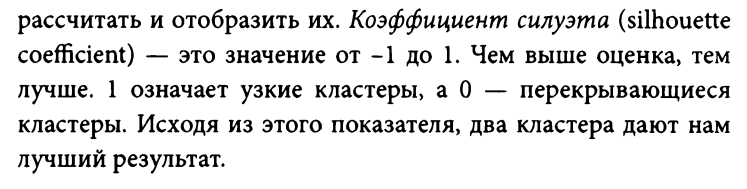
<br></br>
<br></br>

* <h3><b>calinski_harabasz_score</b></h3>

<br></br>
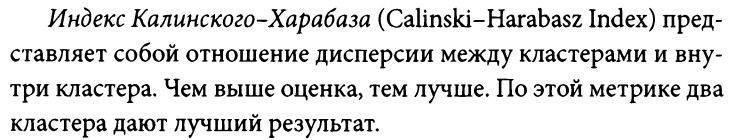
<br></br>
<br></br>

* <h3><b>davies_bouldin_score</b></h3>

<br></br>
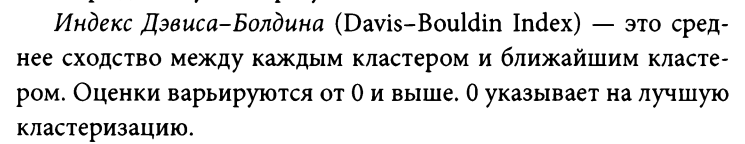

In [38]:
from sklearn import metrics

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

import matplotlib.ticker as ticker

стандартизируем значения атрибутов во всей выборке

In [39]:
X = df
X_std = preprocessing.StandardScaler().fit_transform(X)

выбираем кол-во кластеров с помощью трех метрик

In [40]:
sizes = range(2, 18)
figsize = (28, 15)

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


array([[<AxesSubplot:xlabel='k'>],
       [<AxesSubplot:xlabel='k'>],
       [<AxesSubplot:xlabel='k'>],
       [<AxesSubplot:xlabel='k'>]], dtype=object)

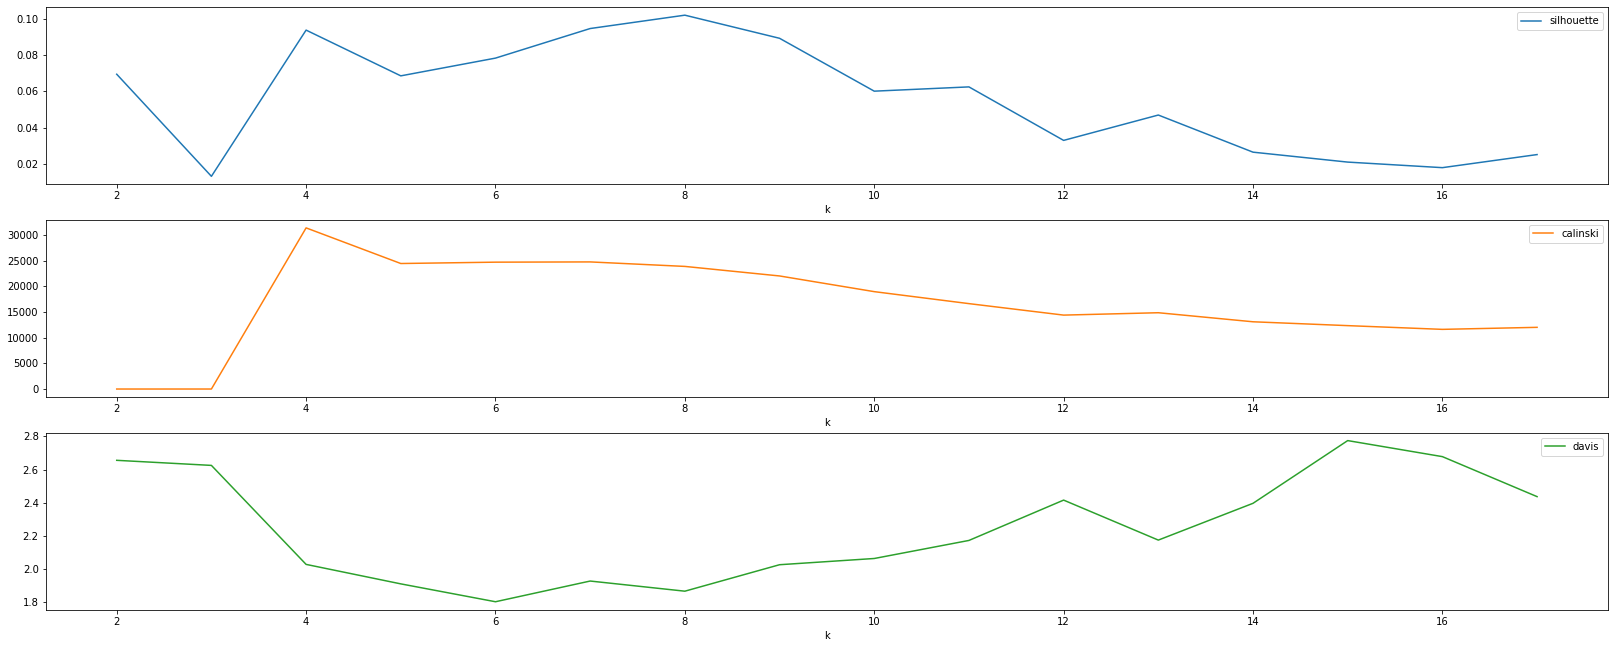

In [41]:
sils = []
chs = []
dbs = []

for k in sizes:
    model = KMeans(random_state=0, n_clusters=k)
    model.fit(X_std)
    
    predict = model.labels_
    
    sils.append(
        metrics.silhouette_score(X, predict)
    )
    chs.append(
        metrics.calinski_harabasz_score(X, predict)
    )
    dbs.append(
        metrics.davies_bouldin_score(X, predict)
    )

fig, ax = plt.subplots(figsize=figsize)
pd.DataFrame(
    {
        "silhouette": sils,
        "calinski": chs,
        "davis": dbs,
        "k": sizes,
    }
).set_index('k').plot(ax=ax, subplots=True, layout=(4, 1))

похоже что большенство этих метрик для модели KMeans согласуются на <b>6</b> кластерах

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


array([[<AxesSubplot:xlabel='k'>, <AxesSubplot:xlabel='k'>],
       [<AxesSubplot:xlabel='k'>, <AxesSubplot:xlabel='k'>]], dtype=object)

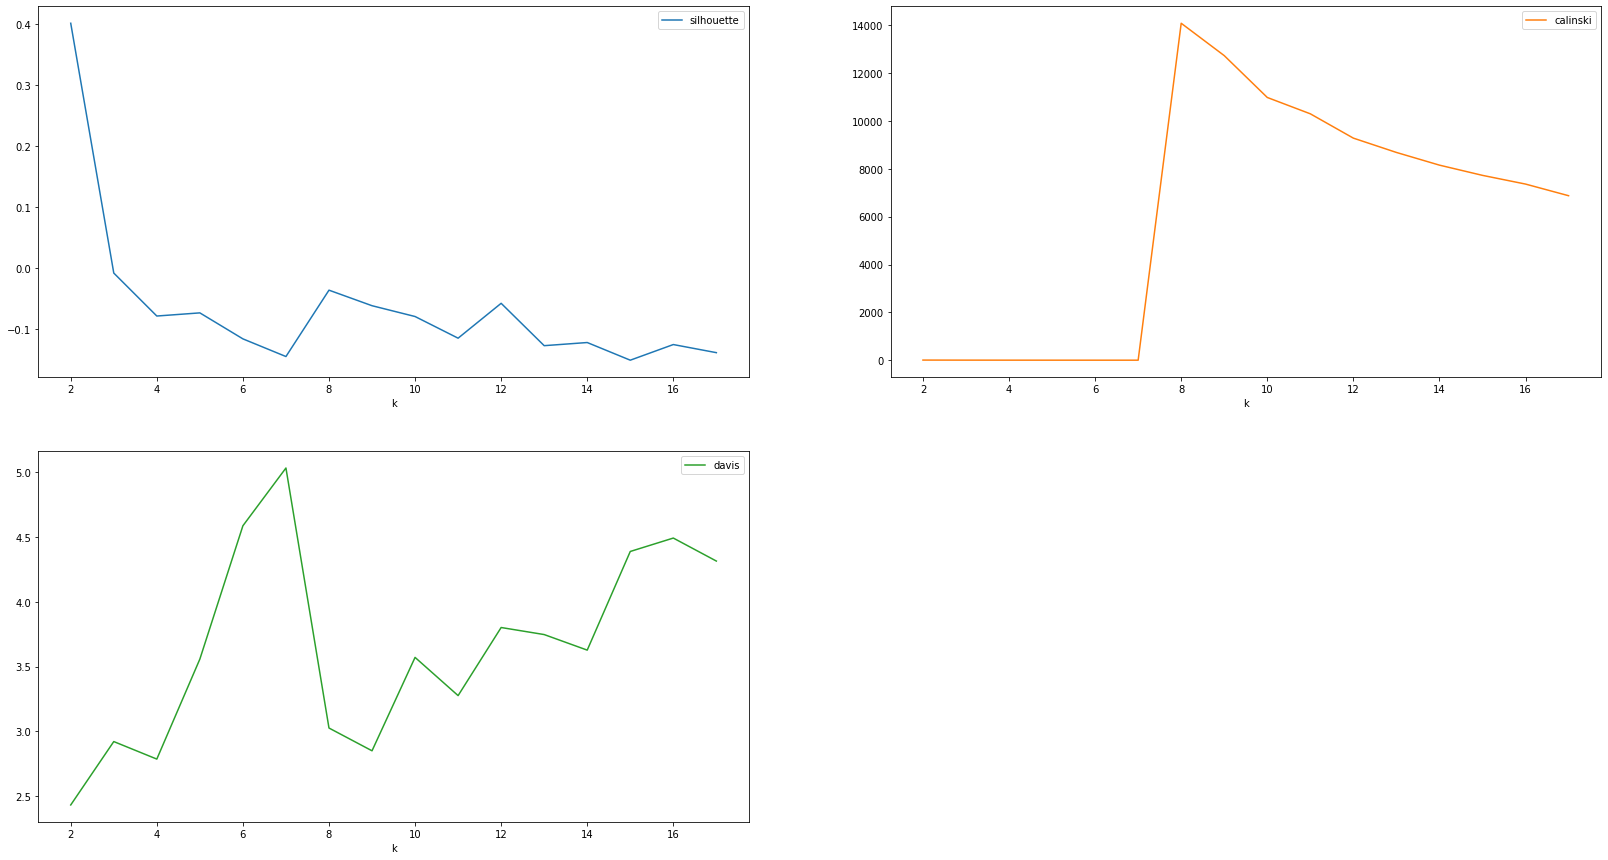

In [42]:
sils = []
chs = []
dbs = []

for k in sizes:
    model = GaussianMixture(n_components=k, random_state=0)
    model.fit(X_std)
    
    predict = model.predict(X_std)
    
    sils.append(
        metrics.silhouette_score(X, predict)
    )
    chs.append(
        metrics.calinski_harabasz_score(X, predict)
    )
    dbs.append(
        metrics.davies_bouldin_score(X, predict)
    )

fig, ax = plt.subplots(figsize=figsize)
pd.DataFrame(
    {
        "silhouette": sils,
        "calinski": chs,
        "davis": dbs,
        "k": sizes,
    }
).set_index('k').plot(ax=ax, subplots=True, layout=(2, 2))

похоже что большенство этих метрик для модели GaussianMixture согласуются на <b>7</b> кластерах

In [43]:
k2 = KMeans(random_state=0, n_clusters=6).fit(X_std)
gm = GaussianMixture(random_state=0, n_components=7).fit(X_std)

In [44]:
m1_predict = k2.labels_
m2_predict = gm.predict(X_std)

In [45]:
sils = {
    "k2": [metrics.silhouette_score(X, m1_predict)],
    "gm": [metrics.silhouette_score(X, m2_predict)]
}
chs = {
    "k2": [metrics.calinski_harabasz_score(X, m1_predict)],
    "gm": [metrics.calinski_harabasz_score(X, m2_predict)]
}
dbs = {
    "k2": [metrics.davies_bouldin_score(X, m1_predict)],
    "gm": [metrics.davies_bouldin_score(X, m2_predict)]
}

<AxesSubplot:>

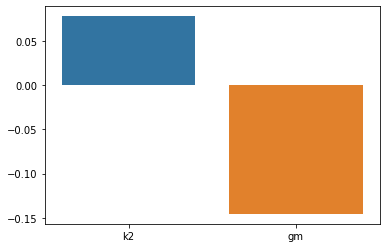

In [46]:
sns.barplot(data=pd.DataFrame(sils))

<AxesSubplot:>

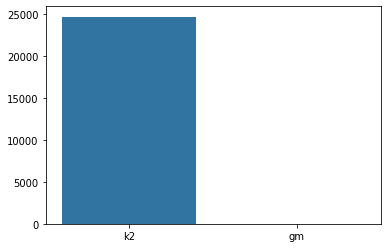

In [47]:
sns.barplot(data=pd.DataFrame(chs))

<AxesSubplot:>

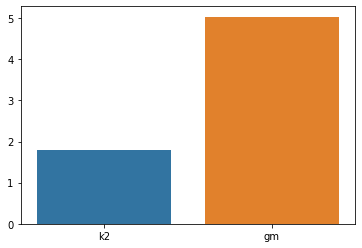

In [48]:
sns.barplot(data=pd.DataFrame(dbs))

In [49]:
from collections import Counter

In [50]:
from sortedcontainers import SortedDict

In [51]:
counts = {}

counts['k2'] = dict(Counter(m1_predict))
counts['gm'] = dict(Counter(m2_predict))

In [52]:
for counter in counts:
    for cluster in counts[counter]:
        counts[counter][cluster] = [counts[counter][cluster]]

<AxesSubplot:>

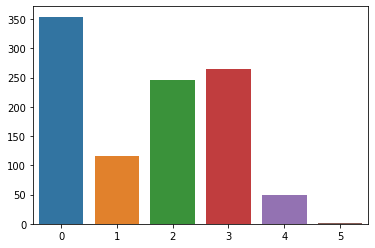

In [53]:
sns.barplot(data=pd.DataFrame(SortedDict(counts['k2'])))

<AxesSubplot:>

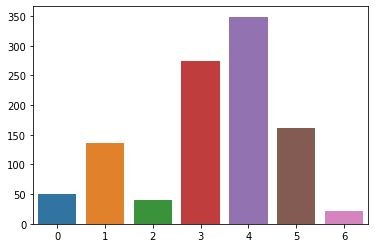

In [54]:
sns.barplot(data=pd.DataFrame(SortedDict(counts['gm'])))

KMeans the best